#  SUSY searches using Machine Learning  

In [1]:
%matplotlib inline
import numpy as np
import sys
import math
from sklearn.preprocessing import Imputer
import os.path
import h5py
import matplotlib.pyplot as plt

In [2]:
from ROOT import gROOT, gDirectory, TFile, TEventList, TCut, TH1F, TH2F, TCanvas, kRed
from root_numpy import tree2array, root2array
%jsroot on

UsageError: Line magic function `%jsroot` not found.


We need to define som function to convert the ROOT nTuples into numpy arrays. One possibility is to read from the nTuple each time and make the numpy array. This can be done by using the following function (buildArraysFromROOT()). It takes as input a TTree, variables to print, selection criteria, which events to write and finally name of the selection.

In [3]:
def buildArraysFromROOT(tree,allowedFeatures,cut,skipEvents,maxEvents,name):
    dataContainer = {}
    featureNames = []
    eventCounter = -1
    gROOT.Reset()
    
    # Get branch names
    for item in tree.GetListOfBranches():
        featureName = item.GetName()
        if featureName in allowedFeatures:
            featureNames.append(featureName)
            dataContainer[featureName] = []

    # Build the event list
    tcut = TCut(cut)
    tree.Draw(">>eventList",tcut)
    eventList = TEventList()
    eventList = gDirectory.Get("eventList")
    nSelectedEvents = eventList.GetN()

    # Event loop
    for i in range(0,nSelectedEvents):
        if (i < skipEvents):
            continue
        if (i % 100 == 0):
            sys.stdout.write("Reading %s: %d%%   \r" % (tree.GetName(),100*i/(maxEvents+skipEvents)) )
            sys.stdout.flush()
        if i >= (maxEvents+skipEvents):
            break
        selectedEvNum = eventList.GetEntry(i)
        tree.GetEntry(selectedEvNum)
        for feature in featureNames:
            dataContainer[feature].append(tree.__getattr__(feature))
    sys.stdout.write("\n")

    # Make the numpy arrays
    outputArray = np.array([])
    for feature in allowedFeatures:
        column = dataContainer[feature]
        feature_vector = np.asarray(column)
        feature_vector = feature_vector.reshape(feature_vector.size,1)
        if outputArray.shape[0]==0:
            outputArray = feature_vector
        else:
            outputArray = np.concatenate((outputArray,feature_vector),axis=1)
    imp = Imputer(missing_values=-999, strategy='mean', axis=0)
    imp.fit(outputArray)
    outputArray = imp.transform(outputArray)
    print(name)
    print("Events: ",outputArray.shape[0])
    print("Features: ",outputArray.shape[1])
    return outputArray

But if one want to play around with the same input many times it is probably better to write the numpy array into a h5 file once and for all and then read from this file (much faster than converting the ntuple). This can be done in the following function. It takes as input the ROOT file, name of tree in the ROOT file, which variable to write, the name of the output (with directory), the cut to use and finally the chunk size (i.e. how much is stored in memory for each iteration of writing to file)

In [4]:
def writeArrays(fileName, treeName, ntupFeatures, outputFileName = "", selection = "", chunkSize = 1000000):
    # ROOT files
    print "Opening ROOT file..."
    if outputFileName:
        outputName = outputFileName+".h5"
    else:
        outputName = fileName[:len(fileName)-5]+".h5"

    inputFile = TFile(fileName)
    inputTree = inputFile.Get(treeName)

    # Chunks
    totalEvents = inputTree.GetEntries()
    nChunks = (totalEvents // chunkSize) + 1
    remainderSize = totalEvents-(nChunks-1)*chunkSize

    # Output file
    with h5py.File(outputName, "w") as f:

       # First chunk (numpy array)
       print "Processing events 0 to",chunkSize
       firstChunk = tree2array(inputTree,start=0,stop=chunkSize,step=1,selection=selection,branches=ntupFeatures)
       n = 0
       if firstChunk.shape[0] == 0: 
            while firstChunk.shape[0] == 0:
                firstChunk = tree2array(inputTree,start=chunkSize*n,
                                            stop=chunkSize*(n+1),step=1,selection=selection,branches=ntupFeatures)
                n += 1
                print "INFO \t Chunk is still empty, trying for the %i%s time "%(n,"nd" if n == 2 else ("rd" if n == 3 else ("st" if n == 1 else "th")))

       # Break into columns
       firstChunk = np.array(firstChunk[:].tolist())
        
       #print f.attrs.keys()
       #return 
       # Output data structure
       dtype = firstChunk.dtype
       row_count = firstChunk.shape[0]
       maxshape = (None,) + firstChunk.shape[1:]
       dset = f.create_dataset(treeName, shape=firstChunk.shape, maxshape=maxshape,chunks=firstChunk.shape, dtype=dtype)
       # Write the first chunk 
       dset[:] = firstChunk
       print type(dset)
       print dset.shape
       #print dset.attrs.create()

       # Loop over chunks
       totalEvents_written = firstChunk.shape[0]
       for chunk in range(chunkSize if n == 0 else chunkSize*n,nChunks*chunkSize,chunkSize):
          start = chunk
          stop = start+chunkSize 
          if (stop>totalEvents): stop = totalEvents 
          print "Processing events ",start," to ",stop      
          # Extraction of data in numpy form, chunk by chunk
          chunk = tree2array(inputTree,
                             start=start,
                             stop=stop,
                             step=1,
                             selection = selection,
                             branches=ntupFeatures)

          totalEvents_written += chunk.shape[0]
          # Break up into columns
          chunk = np.array(chunk[:].tolist())

          # Resize the dataset to accommodate the next chunk of rows
          dset.resize(row_count + chunk.shape[0], axis=0)

          # Write the next chunk
          dset[row_count:] = chunk

          # Increment the row count
          row_count += chunk.shape[0]

       # store the variable names for later
       f.attrs.create('var_names',ntupFeatures)
        
    print "Number of events            = ",totalEvents
    print "Number of events written    = ",totalEvents_written
    print "Number of features          = ",len(ntupFeatures)
    print "Output file name            = ",outputName

Next two cells open the root file with an retrieves the TTree. Then we get the name of all the variables available in the nTuple.

In [5]:
# Input files and TTrees
indir = "/scratch/eirikgr/susy-neuralnetworks/"
inputFile = TFile(indir+"TMVA_tree.root");
tree = inputFile.Get("TMVA_tree")
tree.SetDirectory(0)
inputFile.Close()
#inputFile = TFile("small.root");
#tree = inputFile.Get("TMVA_tree")

In [6]:
susyFeaturesNtup = []
listofbr = tree.GetListOfBranches().Clone()
listofbr.SetOwner(False)
#listofbr.Sort()
for br in listofbr:
    susyFeaturesNtup.append(br.GetName())
print "List of the %i variables in this ntuple: %s" %(len(susyFeaturesNtup),", ".join(susyFeaturesNtup))

List of the 42 variables in this ntuple: lep_pT1, lep_pT2, lep_E1, lep_E2, lep_eta1, lep_eta2, lep_z01, lep_z02, lep_d01, lep_d02, lep_phi1, lep_phi2, lep_d0sig1, lep_d0sig2, lep_z0sintheta1, lep_z0sintheta2, dphi_lep1_met, dphi_lep2_met, lep1_costheta, lep2_costheta, dphi_lep1_lep2, dR_lep1_lep2, hT1, hT2, hT3, hT4, hTmiss, alphaT, mt, met_phi, met, met_x, met_y, mt2, mll, metrel, njet, bnjet, wgt, dsid, isSignal, isBkg


Let's convert the nTuple to a numpy array and write everything to a file. This will take a while:

In [ ]:
writeArrays(indir+"TMVA_tree.root", "TMVA_tree", 
            susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_all_bkg","isSignal==0", 100000)
writeArrays(indir+"TMVA_tree.root", "TMVA_tree", 
            susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_all_sig","isSignal==1", 100000)

# Testing some features on a small file

In [ ]:
#eventFile_bkg.close()
#eventFile_sig.close()
writeArrays("small.root", "TMVA_tree", 
            susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_test_bkg","isSignal==0", 100)
writeArrays("small.root", "TMVA_tree", 
            susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_test_sig","isSignal==1", 100)

Please note that some of these variables should not be used as discriminating variables (e.g. using the isSignal variable would not be fair to include :-)). Also the wgt, massSplit, dsid and isBkg should not be used. We will remove these later, before we start using the data. 

In [ ]:
X = buildArraysFromROOT(tree,susyFeaturesNtup,"",0,100,"ALL")
X[0]
eventFile = h5py.File("/scratch3/eirikgr/ML_files/variables_test.h5","r")
print eventFile.attrs['var_names']
X_test = eventFile["TMVA_tree"]
#susyFeaturesNtup.remove("massSplit")
#susyFeaturesNtup.remove("wgt")
#susyFeaturesNtup.remove("isBkg")
#susyFeaturesNtup.remove("dsid")
#eventFile.close()
print X_test[:].shape
toplot = X_test[:,49]
print toplot.shape
print len(toplot)

In [ ]:
plt.hist(toplot,bins=100);
plt.xlim(0,4);

Just for fun, before we start playing, let's plot the transverse momentum of the hardest lepton (i.e. lepton with the highest transverse momentum in the event) in each event.

In [ ]:
canvas = TCanvas("canvas","canvas",1)
h_lep1_pt = TH1F("h_lep1_pt","p_{T}^{lep1};p_{T} [GeV];Number of entries",200,0,2000)
tree.Draw("lep_pT1/1000>>h_lep1_pt")
h_lep1_pt.Draw("hist")
canvas.SetLogy()
canvas.Draw()

The nTuple contains a mix of signal and background samples. These can be identified by plotting the isSignal variable (equals 1 if event is signal, 0 if background)

In [ ]:
canvas_2 = TCanvas("canvas_2","canvas_2",1)
h_isSignal = TH1F("h_isSignal","isSignal;;Number of entries",2,0,2)
h_isSignal.GetXaxis().SetBinLabel(1,"Background")
h_isSignal.GetXaxis().SetBinLabel(2,"SUSY signal")
tree.Draw("isSignal>>h_isSignal")
h_isSignal.Draw("hist")
canvas_2.SetLogy()
canvas_2.Draw()

There are several signal samples in the nTuple (different SUSY scenarios). These are simplified models which means that they are basically simulations of a single feynman grap (see <a href=https://cds.cern.ch/record/2233683/files/ATL-COM-PHYS-2016-1673.pdf>here</a> for more details). The nTuple used here all signal samples are of the following kind
<img src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/SUSY/FeynmanGraphs/C1C1-llvvN1N1-slsnu.png",width=160,height=160>
where the only difference between the various signal models is the mass difference between the chargino and the neutralino. Let's look at the values for the mass splitting for the available signal models

In [ ]:
canvas_3 = TCanvas("canvas_3","canvas_3",1)
h_massSplit = TH1F("h_massSplit","M(#chi_{1})-M(#chi_{0});Mass split [GeV];Number of entries",400,0,800)
tree.Draw("massSplit>>h_massSplit", "isSignal==1")
h_massSplit.Draw("hist")
#canvas_3.Draw()
canvas_8 = TCanvas("canvas_8","canvas_8",1)
h_massSplit_dsid = TH2F("h_massSplit_dsid","M(#chi_{1}^{#pm})-M(#chi_{1}^{0});Mass split [GeV];Data set ID",400,0,800,22,392500,392521)
tree.Draw("dsid:massSplit>>h_massSplit_dsid", "isSignal==1")
h_massSplit_dsid.Draw("")
canvas_8.Draw()

Define how to divide background from signal

In [ ]:
# Selections
cutBackground = "isSignal==0"
cutSignal = "isSignal==1"

We also need to single out the event weight which makes sure all the background samples are scaled to the same luminosity

In [ ]:
susyWeightsNtup = [ "wgt" ]
susyIdentifierNtup = [ "isSignal" ]

In [ ]:
# Automatic numbers of event 
tcut = TCut(cutSignal)
tree.Draw(">>eventList",tcut)
eventList = TEventList()
eventList = gDirectory.Get("eventList")
nSignalEvents = eventList.GetN()/2
#nSignalEvents = 20000
nBackgroundEvents = nSignalEvents
print "Will use %i events for signal and %i for background" %(nSignalEvents,nBackgroundEvents)

In [ ]:
#canvas_4 = TCanvas("canvas_4","canvas_4",1)
#h_MET_signal = TH1F("h_MET_signal","Missing Transverse Energy;Missing Transverse Energy [GeV];Number of entries",500,0,1000)
#h_MET_backgr = TH1F("h_MET_backgr","Missing Transverse Energy;Missing Transverse Energy [GeV];Number of entries",500,0,1000)
#tree.Draw("met/1000.>>h_MET_signal", cutSignal)
#tree.Draw("met/1000.>>h_MET_backgr", cutBackground)
#h_MET_signal.SetLineColor(kRed)
#h_MET_signal.Scale(1./h_MET_signal.Integral())
#h_MET_backgr.Scale(1./h_MET_backgr.Integral())
#h_MET_backgr.Draw("hist")
#h_MET_signal.Draw("hist same")
#canvas_4.SetLogy()
#canvas_4.Draw()

In [ ]:
#canvas_5 = TCanvas("canvas_5","canvas_5",1)
#h_MEFF_MET_signal = TH2F("h_MEFF_MET_signal","Missing Transverse Energy vs. M_{eff};Missing Transverse Energy [GeV];M_{eff} [GeV]",500,0,1000,500,0,1000)
#h_MEFF_MET_backgr = TH2F("h_MEFF_MET_backgr","Missing Transverse Energy vs. M_{eff};Missing Transverse Energy [GeV];M_{eff} [GeV]",500,0,1000,500,0,1000)
#tree.Draw("met/1000.:meff/1000.>>h_MEFF_MET_signal", cutSignal)
#tree.Draw("met/1000.:meff/1000.>>h_MEFF_MET_backgr", cutBackground)
#h_MET_signal.SetMarkerColor(kRed)
#h_MET_signal.Scale(1./h_MET_signal.Integral())
#h_MET_backgr.Scale(1./h_MET_backgr.Integral())
#h_MET_backgr.Draw("")
#h_MET_signal.Draw("")
#canvas_5.SetLogy()
#canvas_5.Draw()

In [ ]:
# Build data arrays
# Background
X_train_bg = buildArraysFromROOT(tree,susyFeaturesNtup,cutBackground,0,nBackgroundEvents,"TRAINING SAMPLE (background)")
X_test_bg = buildArraysFromROOT(tree,susyFeaturesNtup,cutBackground,nBackgroundEvents,nBackgroundEvents,"TESTING SAMPLE (background)")

# Signal
X_train_sig = buildArraysFromROOT(tree,susyFeaturesNtup,cutSignal,0,nSignalEvents,"TRAINING SAMPLE (signal)")
X_test_sig = buildArraysFromROOT(tree,susyFeaturesNtup,cutSignal,nSignalEvents,nSignalEvents,"TESTING SAMPLE (signal)")

In [ ]:
writeArrays(, selection = "", chunkSize = 1000000)
X_train_bg.shape

# Logistic Regression

In [7]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [8]:
#writeArrays("/mn/felt/u1/eirikgr/Downloads/TMVA_tree.root", "TMVA_tree", 
            #susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_background",cutBackground, 1000000)
#X_bkg = buildArraysFromROOT(tree,susyFeaturesNtup,cutBackground,0,50,"Variable")
#Y_bkg = buildArraysFromROOT(tree,susyIdentifierNtup,cutBackground,0,50,"Signal or no signal")
#X_sig = buildArraysFromROOT(tree,susyFeaturesNtup,cutSignal,0,50,"Variable")
#Y_sig = buildArraysFromROOT(tree,susyIdentifierNtup,cutSignal,0,50,"Signal or no signal")

In [9]:
#writeArrays("/mn/felt/u1/eirikgr/Downloads/TMVA_tree.root", "TMVA_tree", 
            #susyFeaturesNtup, "/scratch3/eirikgr/ML_files/variables_signal",cutSignal, 100000)

Now we're ready to read the numpy array from file and remove the variables we don't want to include as disriminating variables in our fit. 

In [38]:
#backgroundFile = h5py.File("/scratch3/eirikgr/ML_files/variables_background.h5","r")
#signalFile     = h5py.File("/scratch3/eirikgr/ML_files/variables_signal.h5","r")
#eventFile = h5py.File("/scratch3/eirikgr/ML_files/variables_all.h5","r")
#print type(eventFile)
eventFile_bkg = h5py.File("/scratch3/eirikgr/ML_files/variables_all_bkg.h5","r")
eventFile_sig = h5py.File("/scratch3/eirikgr/ML_files/variables_all_sig.h5","r")
attributes = eventFile_bkg.attrs["var_names"]
#print attributes.shape
susyFeaturesExclude = {}
susyFeaturesExclude["massSplit"] = -1
susyFeaturesExclude["wgt"] = -1
susyFeaturesExclude["isBkg"] = -1
susyFeaturesExclude["isSignal"] = -1
susyFeaturesExclude["dsid"] = -1
#print itemindex[0][0]
delitems = []
delitems_agr = []
for sfe in susyFeaturesExclude.keys():
    itemindex = np.where(attributes==sfe)
    if not len(itemindex[0]):
        print "Did not find variable %s in ntuple" %sfe
        continue
    print "Removing variable %-10s in index %i" %(sfe,itemindex[0][0])
    delitems.append(itemindex[0][0])
    susyFeaturesExclude[sfe] = itemindex[0][0]
for sfe in susyFeaturesNtup:
    itemindex = np.where(attributes==sfe)
    if not sfe in ["met","mt2"]:
        delitems_agr.append(itemindex[0][0])
# get the full numpy array
all_var_bkg = eventFile_bkg["TMVA_tree"]
all_var_sig = eventFile_sig["TMVA_tree"]
print "\n"
print "There are a total of %i events in the background nTuple" %(all_var_bkg.shape[0])
print "There are a total of %i events in the signal nTuple" %(all_var_sig.shape[0])
print "\n"
# get the signal/no-signal vector
Y_bkg = all_var_bkg[:,susyFeaturesExclude["isSignal"]]
Y_sig = all_var_sig[:,susyFeaturesExclude["isSignal"]]
# get the weights
W_bkg = all_var_bkg[:,susyFeaturesExclude["wgt"]]
W_sig = all_var_sig[:,susyFeaturesExclude["wgt"]]
# get the numpy array without the unwanted variables
X_bkg = np.delete(all_var_bkg,delitems,1)
X_sig = np.delete(all_var_sig,delitems,1)

print "Backgrounds are now stored in X_bkg with %i entries and %i variables" %(X_bkg.shape[0],X_bkg.shape[1])
print "Signals     are now stored in X_sig with %i entries and %i variables" %(X_sig.shape[0],X_sig.shape[1])
print "\n"
print "Target  for background is now stored in Y_bkg with %i entries" %(Y_bkg.shape[0])
print "Weights for background are now stored in W_bkg with %i entries" %(W_bkg.shape[0])
print "\n"
print "Target  for signals is now stored in Y_sig with %i entries" %(Y_sig.shape[0])
print "Weights for signals are now stored in W_sig with %i entries" %(W_sig.shape[0])

Removing variable dsid       in index 39
Did not find variable massSplit in ntuple
Removing variable isSignal   in index 40
Removing variable isBkg      in index 41
Removing variable wgt        in index 38


There are a total of 2252531 events in the background nTuple
There are a total of 245201 events in the signal nTuple


Backgrounds are now stored in X_bkg with 2252531 entries and 38 variables
Signals     are now stored in X_sig with 245201 entries and 38 variables


Target  for background is now stored in Y_bkg with 2252531 entries
Weights for background are now stored in W_bkg with 2252531 entries


Target  for signals is now stored in Y_sig with 245201 entries
Weights for signals are now stored in W_sig with 245201 entries


In [39]:
delitems_agr

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

Get the number of events for each data set ID (dsid). We want to train on all the various backgrounds and signal.

In [11]:
if not type(eventFile_bkg) is h5py._hl.files.File:
    eventFile_bkg = h5py.File("/scratch3/eirikgr/ML_files/variables_all_bkg.h5","r")
if not type(eventFile_sig) is h5py._hl.files.File:
    eventFile_sig = h5py.File("/scratch3/eirikgr/ML_files/variables_all_sig.h5","r")
attributes = eventFile_sig.attrs["var_names"]
#print attributes.shape
susyFeaturesExclude = {}
susyFeaturesExclude["massSplit"] = -1
susyFeaturesExclude["wgt"] = -1
susyFeaturesExclude["isBkg"] = -1
susyFeaturesExclude["isSignal"] = -1
susyFeaturesExclude["dsid"] = -1
#print itemindex[0][0]
delitems = []
for sfe in susyFeaturesExclude.keys():
    itemindex = np.where(attributes==sfe)
    if not len(itemindex[0]):
        print "Did not find variable %s in ntuple" %sfe
        continue
    print "Unwanted variable %-10s in index %i" %(sfe,itemindex[0][0])
    delitems.append(itemindex[0][0])
    susyFeaturesExclude[sfe] = itemindex[0][0]
# get the full numpy array
all_var_bkg = eventFile_bkg["TMVA_tree"]
all_var_sig = eventFile_sig["TMVA_tree"]
print "\n"
print "There are a total of %i events in the background nTuple" %(all_var_bkg.shape[0])
print "There are a total of %i events in the signal nTuple" %(all_var_sig.shape[0])
print "\n"

Unwanted variable dsid       in index 39
Did not find variable massSplit in ntuple
Unwanted variable isSignal   in index 40
Unwanted variable isBkg      in index 41
Unwanted variable wgt        in index 38


There are a total of 2252531 events in the background nTuple
There are a total of 245201 events in the signal nTuple




Let's produce the data set to train on. Should be a mix of backgrounds and signals. 

In [12]:
rBackgroundEvents = 0.2
rSignalEvents = 0.2
X_train_bkg = {}
X_train_sig = {}
X_test_bkg  = {}
X_test_sig  = {}
W_train_bkg = {}
W_train_sig = {}
W_test_bkg  = {}
W_test_sig  = {}
counts_dsids = {}

In [13]:
dsids = np.concatenate((all_var_bkg[:,susyFeaturesExclude["dsid"]],all_var_sig[:,susyFeaturesExclude["dsid"]]),axis=0)
print "There are %i unique data sets in the signal and background samples" %np.unique(dsids).shape[0]
n = 0
for dsid in np.unique(dsids):
    #
    #if (dsid >= 392500 and dsid <= 392521): continue
    print "Doing dsid %i/%i" %(n,np.unique(dsids).shape[0])
    num = 0
    isBkg = True
    indexs = np.where(all_var_bkg[:,susyFeaturesExclude["dsid"]] == dsid)
    num = indexs[0].shape[0]
    if not num: 
        indexs = np.where(all_var_sig[:,susyFeaturesExclude["dsid"]] == dsid)
        num = indexs[0].shape[0]
        isBkg = False
    if num < 5: 
        print "Skipping %i since only %i events" %(dsid,num)
        continue
    if isBkg:
        counts_dsids[dsid] = num
        X_train_bkg[dsid] = all_var_bkg[indexs[0][:int(math.ceil(num*rBackgroundEvents))],:]
        X_test_bkg[dsid]  = all_var_bkg[indexs[0][int(math.ceil(num*rBackgroundEvents)):],:]
    else:   
        num = indexs[0].shape[0]
        print num
        counts_dsids[dsid] = num
        X_train_sig[dsid] = all_var_sig[indexs[0][:int(math.ceil(num*rSignalEvents))],:]
        X_test_sig[dsid]  = all_var_sig[indexs[0][int(math.ceil(num*rSignalEvents)):],:]
        print X_train_sig[dsid].shape[0]
    n += 1
        
for dsid in sorted(counts_dsids.keys()):
    if dsid in X_train_bkg.keys():
        W_train_bkg[dsid] = X_train_bkg[dsid][:,susyFeaturesExclude["wgt"]]
        W_test_bkg[dsid]  = X_test_bkg[dsid][:,susyFeaturesExclude["wgt"]]
        print "DSID %i has %i events and %i (%i) events used for training (testing)" %(int(dsid),counts_dsids[dsid],X_train_bkg[dsid].shape[0],X_test_bkg[dsid].shape[0])
    elif dsid in X_train_sig.keys():
        W_train_sig[dsid] = X_train_sig[dsid][:,susyFeaturesExclude["wgt"]]
        W_test_sig[dsid]  = X_test_sig[dsid][:,susyFeaturesExclude["wgt"]]
        print "DSID %i has %i events and %i (%i) events used for training (testing)" %(int(dsid),counts_dsids[dsid],X_train_sig[dsid].shape[0],X_test_sig[dsid].shape[0])   

There are 260 unique data sets in the signal and background samples
Doing dsid 0/260
Doing dsid 1/260
Doing dsid 2/260
Doing dsid 3/260
Doing dsid 4/260
Doing dsid 5/260
Doing dsid 6/260
Doing dsid 7/260
Doing dsid 8/260
Doing dsid 9/260
Doing dsid 10/260
Doing dsid 11/260
Doing dsid 12/260
Doing dsid 13/260
Doing dsid 14/260
Doing dsid 15/260
Doing dsid 16/260
Doing dsid 17/260
Doing dsid 18/260
Doing dsid 19/260
Doing dsid 20/260
Doing dsid 21/260
Doing dsid 22/260
Doing dsid 23/260
Doing dsid 24/260
Doing dsid 25/260
Doing dsid 26/260
Doing dsid 27/260
Doing dsid 28/260
Doing dsid 29/260
Doing dsid 30/260
Doing dsid 31/260
Doing dsid 32/260
Doing dsid 33/260
Doing dsid 34/260
Doing dsid 35/260
Doing dsid 36/260
Doing dsid 37/260
Doing dsid 38/260
Doing dsid 39/260
Doing dsid 40/260
Doing dsid 41/260
Doing dsid 42/260
Doing dsid 43/260
Skipping 361300 since only 4 events
Doing dsid 43/260
Doing dsid 44/260
Doing dsid 45/260
Skipping 361303 since only 4 events
Doing dsid 45/260
Doing 

In [14]:
W_train = np.array([])
X_train = np.array([])
W_test  = np.array([])
X_test  = np.array([])
n = 1
for dsid in sorted(counts_dsids.keys()):
    if dsid in X_train_bkg.keys():
        if X_train.shape[0] == 0:
            X_train = np.copy(X_train_bkg[dsid])
            W_train = np.copy(W_train_bkg[dsid])
            X_test = np.copy(X_test_bkg[dsid])
            W_test = np.copy(W_test_bkg[dsid])
        else:
            X_train = np.concatenate((X_train_bkg[dsid],X_train),axis=0)
            W_train = np.concatenate((W_train_bkg[dsid],W_train),axis=0)
            X_test  = np.concatenate((X_test_bkg[dsid],X_test),axis=0)
            W_test  = np.concatenate((W_test_bkg[dsid],W_test),axis=0)
        print "Adding %i/%i with %i events to training sample. Now is %i" %(n,len(counts_dsids.keys()),X_train_bkg[dsid].shape[0],X_train.shape[0])
    elif dsid in X_train_sig.keys():
        if X_train.shape[0] == 0:
            X_train = np.copy(X_train_sig[dsid])
            W_train = np.copy(W_train_sig[dsid])
            X_test  = np.copy(X_test_sig[dsid])
            W_test  = np.copy(W_test_sig[dsid])
        else:
            X_train = np.concatenate((X_train_sig[dsid],X_train),axis=0)
            W_train = np.concatenate((W_train_sig[dsid],W_train),axis=0)
            X_test  = np.concatenate((X_test_sig[dsid],X_test),axis=0)
            W_test  = np.concatenate((W_test_sig[dsid],W_test),axis=0)
        print "Adding %i/%i with %i events to training sample. Now is %i" %(n,len(counts_dsids.keys()),X_train_sig[dsid].shape[0],X_train.shape[0])
   
        
    n += 1

Adding 1/254 with 233 events to training sample. Now is 233
Adding 2/254 with 4531 events to training sample. Now is 4764
Adding 3/254 with 27 events to training sample. Now is 4791
Adding 4/254 with 102 events to training sample. Now is 4893
Adding 5/254 with 144 events to training sample. Now is 5037
Adding 6/254 with 26 events to training sample. Now is 5063
Adding 7/254 with 99 events to training sample. Now is 5162
Adding 8/254 with 138 events to training sample. Now is 5300
Adding 9/254 with 15 events to training sample. Now is 5315
Adding 10/254 with 42 events to training sample. Now is 5357
Adding 11/254 with 24 events to training sample. Now is 5381
Adding 12/254 with 1549 events to training sample. Now is 6930
Adding 13/254 with 4445 events to training sample. Now is 11375
Adding 14/254 with 7171 events to training sample. Now is 18546
Adding 15/254 with 3132 events to training sample. Now is 21678
Adding 16/254 with 5094 events to training sample. Now is 26772
Adding 17/254 

Adding 133/254 with 213 events to training sample. Now is 192024
Adding 134/254 with 7151 events to training sample. Now is 199175
Adding 135/254 with 8974 events to training sample. Now is 208149
Adding 136/254 with 8233 events to training sample. Now is 216382
Adding 137/254 with 9432 events to training sample. Now is 225814
Adding 138/254 with 9702 events to training sample. Now is 235516
Adding 139/254 with 8689 events to training sample. Now is 244205
Adding 140/254 with 11680 events to training sample. Now is 255885
Adding 141/254 with 3496 events to training sample. Now is 259381
Adding 142/254 with 1104 events to training sample. Now is 260485
Adding 143/254 with 11099 events to training sample. Now is 271584
Adding 144/254 with 4039 events to training sample. Now is 275623
Adding 145/254 with 2584 events to training sample. Now is 278207
Adding 146/254 with 566 events to training sample. Now is 278773
Adding 147/254 with 691 events to training sample. Now is 279464
Adding 148/

In [15]:
# check that the shapes match and make the target vector (Y)
print W_train.shape
print X_train.shape
Y_train = np.where(X_train[:,susyFeaturesExclude["isSignal"]],1,0)
print Y_train.shape

(499647,)
(499647, 42)
(499647,)


In [16]:
# check that the shapes match and make the target vector (Y)
print W_test.shape
print X_test.shape
Y_test = np.where(X_test[:,susyFeaturesExclude["isSignal"]],1,0)
print Y_test.shape

(1998068,)
(1998068, 42)
(1998068,)


In [17]:
X_train_clean = np.delete(X_train,delitems,1)
X_test_clean = np.delete(X_test,delitems,1)
print X_test_clean.shape
print "TRAIN sample: Removed %i variables (%s), shape is now (%s,%s)" %(len(delitems),",".join(susyFeaturesExclude),X_train_clean.shape[0],X_train_clean.shape[1])
print "TEST  sample: Removed %i variables (%s), shape is now (%s,%s)" %(len(delitems),",".join(susyFeaturesExclude),X_test_clean.shape[0],X_test_clean.shape[1])

(1998068, 38)
TRAIN sample: Removed 4 variables (dsid,massSplit,isSignal,isBkg,wgt), shape is now (499647,38)
TEST  sample: Removed 4 variables (dsid,massSplit,isSignal,isBkg,wgt), shape is now (1998068,38)


In [18]:
degree = 2
lambda_=1e-5
logreg = linear_model.LogisticRegression(C=1/lambda_,max_iter=200)

In [19]:
susyFeaturesExclude["isSignal"]

40

In [59]:
logreg.fit(X_train_clean, Y_train.ravel(),W_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

<BarContainer object of 38 artists>

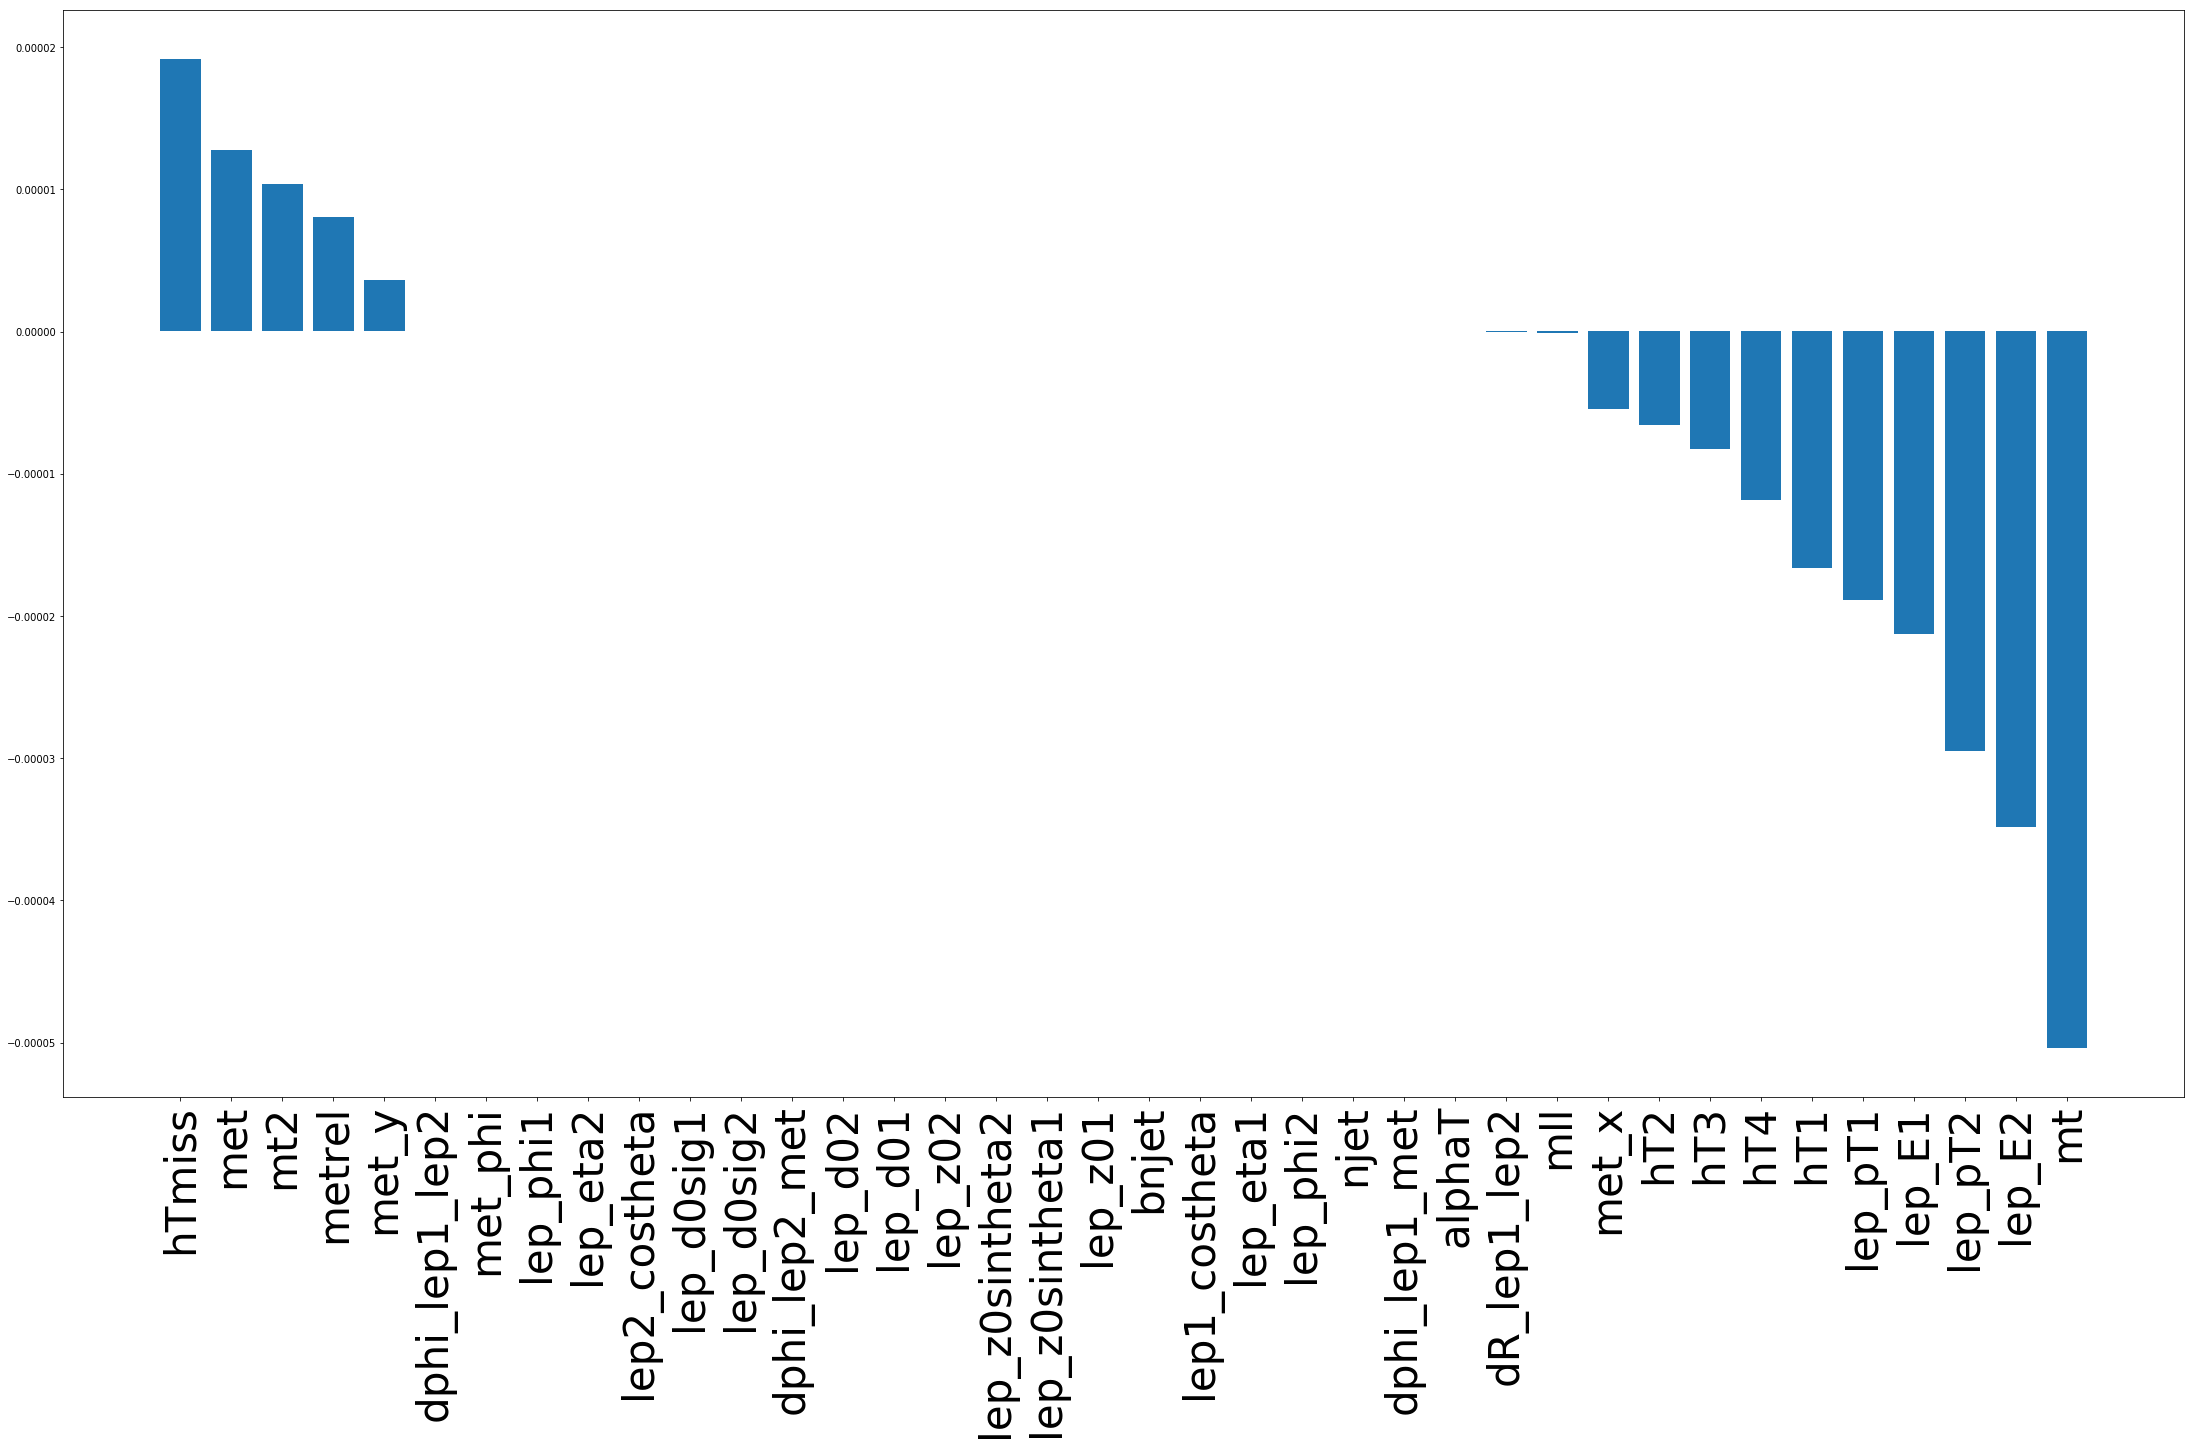

In [21]:
sorted_coeff = np.sort(logreg.coef_[0])
i = 1
data = np.arange(len(sorted_coeff),dtype="f")
label = np.arange(len(sorted_coeff),dtype='object')
for sc in reversed(sorted_coeff):
    itemindex = np.where(logreg.coef_[0]==sc)
    label[i-1] = attributes[itemindex[0][0]]
    data[i-1] = float(sc)
    i += 1
plt.figure(figsize=(38,20))
plt.xticks(rotation='vertical',fontsize=42)
plt.bar(np.arange(i-1),data,tick_label=label,bottom=1e-8)

In [22]:
def print_score(X,Y,logreg):
    predictions=logreg.predict(X)
    print('Accuracy:', accuracy_score(Y, predictions))
    print('Precision:', precision_score(Y, predictions, average='macro'))
    print('Recall:', recall_score(Y, predictions, average='macro'))
    return predictions

In [61]:
pred = print_score(X_train_clean, Y_train,logreg)
logreg.decision_function(X_train_clean)

('Accuracy:', 0.9018326938818806)
('Precision:', 0.7009171511773359)
('Recall:', 0.5000090842512175)


array([-23.18771715, -16.44136175, -42.72646954, ...,  -9.90849999,
       -19.10973757,  -8.23693658])

The code below plots the decision curve for the logreg for background and signal. The ROOT histograms are used for finding the optimal cut on the decision curve for optimizing the significance.

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_signal (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_backgr (Potential memory leak).


Number of background events =  450598
Number of signal events     =  49049


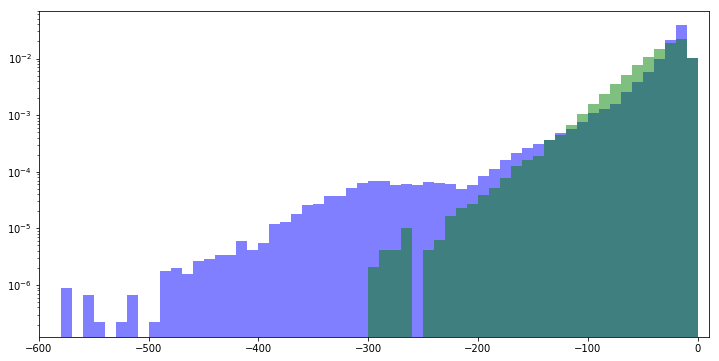

In [96]:
# ROOT histohgrams for finding the optimal cut (not used for plotting)
h_signal = TH1F("h_signal","h_signal",100,-1000,0)
h_backgr = TH1F("h_backgr","h_backgr",100,-1000,0)
# Get the decision function for the training sample
dec = logreg.decision_function(X_train_clean)
# Need to know how many signal events and background events 
# there are in the training set in order to create the numpy arrays
unique, counts = np.unique(Y_train, return_counts=True)
print "Number of background events = ",dict(zip(unique, counts))[0]
print "Number of signal events     = ",dict(zip(unique, counts))[1]
# Create the numpy arrays used for plotting
x_sig = np.zeros(dict(zip(unique, counts))[1])
x_bkg = np.zeros(dict(zip(unique, counts))[0])
fig = plt.figure(1, figsize=(12, 6))
nsig = 0
nbkg = 0
# Loops over the decision fuction and fills the background/signal numpy arrays (used for plotting)
# and the ROOT histograms used for finding the optimal cut
for i in range(len(dec)):
    if Y_train[i] == 0:
        x_bkg[nbkg] = dec[i]
        h_backgr.Fill(dec[i],W_train[i])
        nbkg += 1
    else:
        x_sig[nsig] = dec[i]
        h_signal.Fill(dec[i],W_train[i])
        nsig += 1
    #print dec[i]
binw = 10
bins = np.arange(-1000, 10, 10)
plt.hist(x_bkg,bins,alpha=0.5,color="b", density=True)
plt.hist(x_sig,bins,alpha=0.5,color="g", density=True)
plt.xlim(-600,10)
plt.yscale("log")
plt.show()

The cell below loops over the histograms with the decision fuctions for signal and background and calculates the optimal cut to maximize the significance.

In [98]:
from ROOT import RooStats, Double
import math
err_sig = Double(0)
err_bkg = Double(0)
max_sig = -9999
max_nsig = -1
max_nbkg = -1
for i in range(1,h_signal.GetNbinsX()):
    #print "from ",h_signal.GetBinLowEdge(i)
    nsig = h_signal.IntegralAndError(i,h_signal.GetNbinsX()+1,err_sig)
    nbkg = h_backgr.IntegralAndError(i,h_signal.GetNbinsX()+1,err_bkg)
    if nbkg == 0 or nsig == 0: continue 
    sign = RooStats.NumberCountingUtils.BinomialExpZ(nsig, nbkg,math.sqrt((err_sig*err_sig) + (err_bkg*err_bkg)))
    #print nsig, nbkg, sign
    if sign > max_sig:
        max_sig  = sign
        max_nsig = nsig
        max_nbkg = nbkg
        max_bin  = i
print "Max significance = %.2f (nbkg = %.2f, nsig = %.2f) in bin %i at value %.1f" %(max_sig,
                                                                                   max_nbkg,
                                                                                   max_nsig,
                                                                                   max_bin,
                                                                                   h_signal.GetBinLowEdge(max_bin))

Max significance = -5.66 (nbkg = 1472790.35, nsig = 60.14) in bin 99 at value -20.0


SystemError: void TH1::Draw(const char* option = "") =>
    problem in C++; program state has been reset

In [24]:
#X_test_clean = np.delete(X_test,delitems,1)
print_score(X_test_clean, Y_test,logreg)

('Accuracy:', 0.9018296674587651)
('Precision:', 0.717582883603855)
('Recall:', 0.5000184499718986)


array([0, 0, 0, ..., 0, 0, 0])

In [25]:
pred = logreg.predict(X_test_clean)
dsid      = np.concatenate((all_var_bkg[:,39],all_var_sig[:,39]),axis=0)
#masssplit = np.concatenate((all_var_bkg[:,53],all_var_sig[:,53]),axis=0)
wgt       = np.concatenate((W_bkg,W_sig),axis=0)
predRight = 0.
predWrong = 0.
yields    = {}
label = np.arange(len(sorted_coeff),dtype='object')
for i in range(len(pred)):
    if not dsid[i] in yields.keys():
        yields[dsid[i]] = {"nbkg":0,"nsig":0}
    if pred[i]: yields[dsid[i]]["nsig"] += wgt[i]
    else: yields[dsid[i]]["nbkg"] += wgt[i]
    #print "Predicted %i, true is %i" %(pred[i],Y_test[i])
    if pred[i] == Y_test[i]:
        predRight += 1.
    else:
        predWrong += 1.
print "Got it right in %.2f of the cases!" %(predRight/float(i))
#print yields

Got it right in 0.90 of the cases!


In [ ]:
h_MET_sig = TH1F("h_MET_sig","",100,0,1000)
h_MET_bkg = TH1F("h_MET_bkg","",100,0,1000)
n = 0
for p in pred:
    if p == 0:
        h_MET_bkg.Fill(X_test[n][19]/1000.)
    if p == 1:
        h_MET_sig.Fill(X_test[n][19]/1000.)
    n += 1
    
canvas_6 = TCanvas("canvas_6","canvas_6",1)
h_MET_sig.SetLineColor(kRed)
h_MET_bkg.Draw("hist")
h_MET_sig.Draw("same hist")
canvas_6.SetLogy()
canvas_6.Draw()

In [44]:
X_train_agr = np.delete(X_train,delitems_agr,1)
X_test_agr = np.delete(X_test,delitems_agr,1)
logreg.fit(X_train_agr, Y_train.ravel(),W_train)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [45]:
pred = print_score(X_train_agr, Y_train,logreg)

('Accuracy:', 0.9018326938818806)
('Precision:', 0.4509163469409403)
('Recall:', 0.5)


In [56]:
def plot_boundary(X,y,degree,logreg):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    print "x_min = ",x_min
    print "x_max = ",x_max
    print "y_min = ",y_min
    print "y_max = ",y_max
    h = 10000  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
    #xs, ys = np.meshgrid(np.linspace(x_min, x_max, 200),np.linspace(y_min, y_max, 200))
    #xys = mapFeature(xs.ravel(),ys.ravel(),degree)
    #print(xys.shape)
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()
    #plt.pcolormesh(xs, ys, Z, cmap=plt.cm.Paired)
    #plt.scatter(X[:, 1], X[:, 2], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    #plt.xlim(xs.min(), xs.max())
    #plt.ylim(ys.min(), ys.max())
    #plt.xticks(())
    #plt.yticks(())
    return plt

In [49]:
def mapFeature(X1, X2, degree):
    out = np.ones(( X1.shape[0], sum(range(degree + 2)) )) # could also use ((degree+1) * (degree+2)) / 2 instead of sum
    curr_column = 1
    for i in range(1, degree + 1):
        for j in range(i+1):
            out[:,curr_column] = np.power(X1,i-j) * np.power(X2,j)
            curr_column += 1
    return out

In [ ]:
print X_test_clean[:,:2]

x_min =  27.617568969726562
x_max =  70030784.0
y_min =  80.510986328125
y_max =  5304406.5


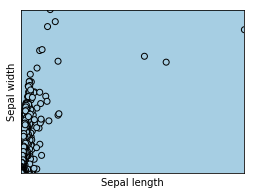

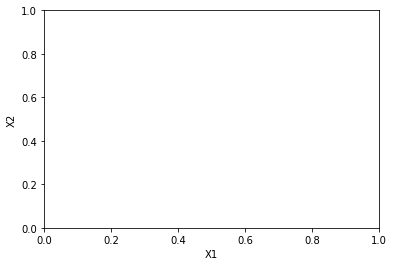

In [57]:
import matplotlib.pyplot as plt
plt=plot_boundary(X_test_agr,Y_test,degree,logreg)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [27]:
X_test_clean[:,:2]

array([[37428.69921875, 25036.35351562],
       [68546.2734375 , 32539.0625    ],
       [25995.76757812, 17091.44140625],
       ...,
       [46218.00390625, 45153.94921875],
       [36841.99609375, 24861.45507812],
       [38124.8125    , 24685.95703125]])